In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

C:\Users\latif\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data Acquisition

In [2]:
train_dir = r"C:\Users\latif\Downloads\Brain Tumor Data\Training"
test_dir = r"C:\Users\latif\Downloads\Brain Tumor Data\Testing"

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Data Augmentation for Training

In [4]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,             
    horizontal_flip=True,       
    vertical_flip=False,        
    validation_split=0.2        
)

In [5]:
test_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  
)

Found 2297 images belonging to 4 classes.


In [7]:
val_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  
)

Found 573 images belonging to 4 classes.


In [8]:
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  
)

Found 394 images belonging to 4 classes.


In [9]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_values = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights_values))

In [10]:
print(train_data.class_indices)
print(val_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


# Preview Dataset

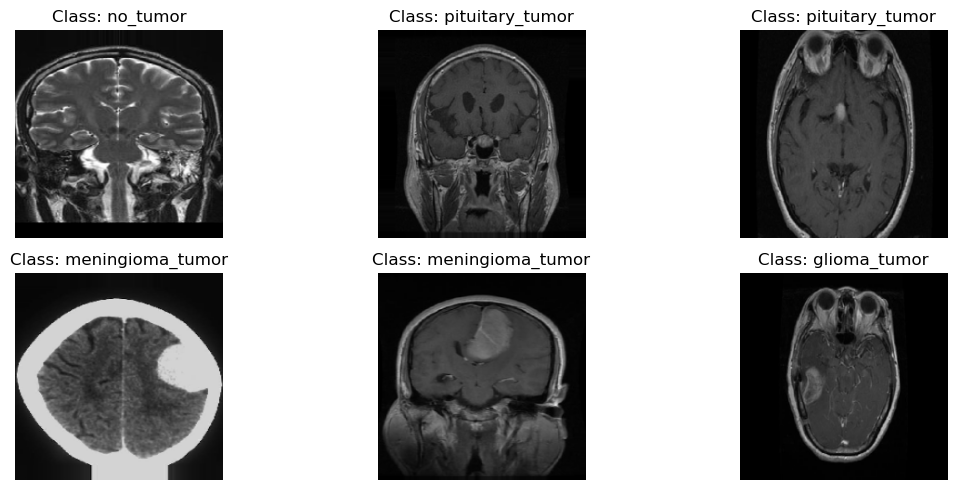

In [11]:

class_names = list(train_data.class_indices.keys())

x_sample, y_sample = next(train_data)
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_sample[i])
    plt.title(f"Class: {class_names[np.argmax(y_sample[i])]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# CNN Model

In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(*IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

Compiling the model

In [13]:
model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Callbacks for better training control
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

Training the model

In [16]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/30


72/72 [==============================] - ETA: 0s - loss: 1.6015 - accuracy: 0.5050

C:\Users\latif\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 97s 1s/step - loss: 1.6015 - accuracy: 0.5050 - val_loss: 3.2236 - val_accuracy: 0.2949 - lr: 1.0000e-04
Epoch 2/30
72/72 [==============================] - 70s 976ms/step - loss: 0.9758 - accuracy: 0.5703 - val_loss: 5.0649 - val_accuracy: 0.3682 - lr: 1.0000e-04
Epoch 3/30
72/72 [==============================] - 68s 944ms/step - loss: 0.8776 - accuracy: 0.6204 - val_loss: 4.7169 - val_accuracy: 0.4293 - lr: 1.0000e-04
Epoch 4/30
72/72 [==============================] - 68s 939ms/step - loss: 0.8274 - accuracy: 0.6478 - val_loss: 2.9471 - val_accuracy: 0.3752 - lr: 1.0000e-04
Epoch 5/30
72/72 [==============================] - 71s 983ms/step - loss: 0.7644 - accuracy: 0.6787 - val_loss: 1.4762 - val_accuracy: 0.5166 - lr: 1.0000e-04
Epoch 6/30
72/72 [==============================] - 73s 1s/step - loss: 0.7705 - accuracy: 0.6726 - val_loss: 1.1996 - val_accuracy: 0.5358 - lr: 1.0000e-04
Epoch 7/30
72/72 [==============================] - 69s 9

In [17]:
model.save("brain_tumor_model.h5")

# Plotting Accuracy and Loss

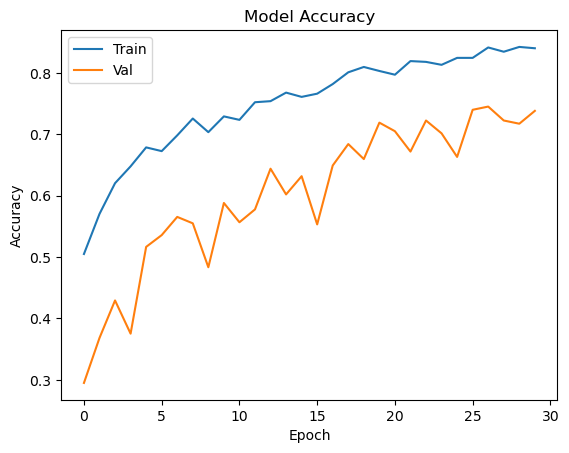

In [18]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

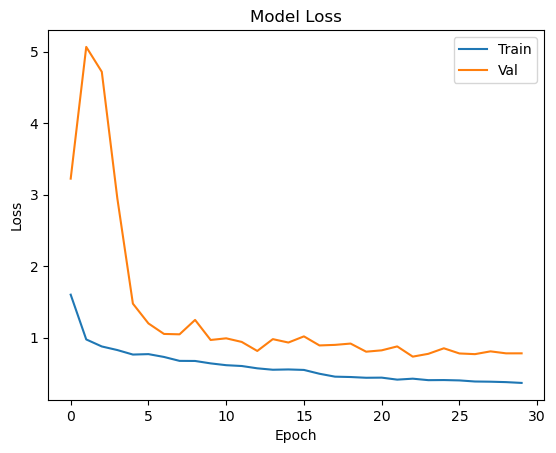

In [19]:
# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Making Predictions on Test data

In [20]:
pred_probs = model.predict(test_data)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())


13/13 [==============================] - 6s 455ms/step


Computing Confusion Matrix

In [23]:
import numpy as np


steps = test_data.samples // test_data.batch_size + int(test_data.samples % test_data.batch_size != 0)


pred_probs = model.predict(test_data, steps=steps)


pred_classes = np.argmax(pred_probs, axis=1)



13/13 [==============================] - 3s 206ms/step


In [24]:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())


In [25]:
print("Predicted:", len(pred_classes))
print("True labels:", len(true_classes))


Predicted: 394
True labels: 394


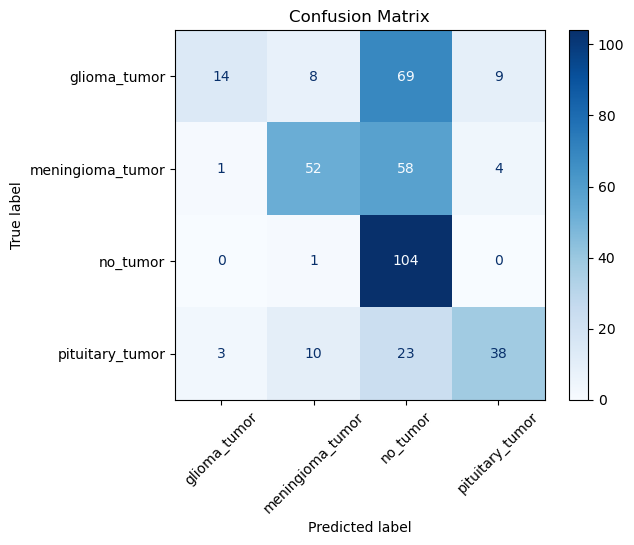


Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.78      0.14      0.24       100
meningioma_tumor       0.73      0.45      0.56       115
        no_tumor       0.41      0.99      0.58       105
 pituitary_tumor       0.75      0.51      0.61        74

        accuracy                           0.53       394
       macro avg       0.67      0.52      0.50       394
    weighted avg       0.66      0.53      0.49       394



In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Visualizing image with GradCam

In [28]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [29]:
def overlay_heatmap(heatmap, image, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
    return overlayed

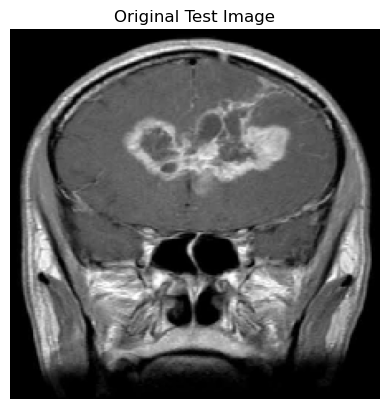

In [30]:
# Get one batch from the test data
images, labels = next(test_data)

# Choose an image index
img_index = 0
img = images[img_index]
img_array = np.expand_dims(img, axis=0)

# Display original image
plt.imshow(img)
plt.axis('off')
plt.title("Original Test Image")
plt.show()


In [32]:
import tensorflow as tf
last_conv_layer_name = 'conv2d_2'  # Replace if different
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


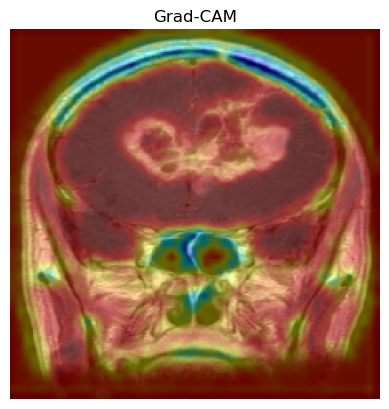

In [34]:
import cv2

img_uint8 = np.uint8(img * 255)

overlayed_img = overlay_heatmap(heatmap, img_uint8)

plt.imshow(overlayed_img)
plt.axis('off')
plt.title("Grad-CAM")
plt.show()


In [35]:
cv2.imwrite('gradcam_output.jpg', cv2.cvtColor(overlayed_img, cv2.COLOR_RGB2BGR))


True